In [58]:
import jax
import numpy as np
import jax.numpy as jnp
import hydra
import ray
from omegaconf import OmegaConf
from jaxman.env.navigation.env import JaxMANEnv
from jaxman.env.pick_and_delivery.env import JaxPandDEnv
from jaxman.planner.rl_planner.agent.core import create_agent, restore_agent
from jaxman.planner.rl_planner.rollout.rollout import _build_rollout_episode
from jaxman.planner.rl_planner.worker import GlobalBuffer
from typing import NamedTuple, Any
import matplotlib.pyplot as plt
env_config = hydra.utils.instantiate(
    OmegaConf.load("../scripts/config/env/navigation/continuous.yaml")
)
model_config = hydra.utils.instantiate(
    OmegaConf.load("../scripts/config/model/sac.yaml")
)
train_config = hydra.utils.instantiate(
    OmegaConf.load("../scripts/config/train/sac.yaml")
)
env_config.obs_type="room"
env_config.level=2
env_config.num_agents=1
from hydra import initialize, compose
from omegaconf import OmegaConf

with initialize(version_base=None, config_path="../scripts/config"):
    cfg = compose(config_name='train_rl.yaml')
cfg.train.batch_size=1000

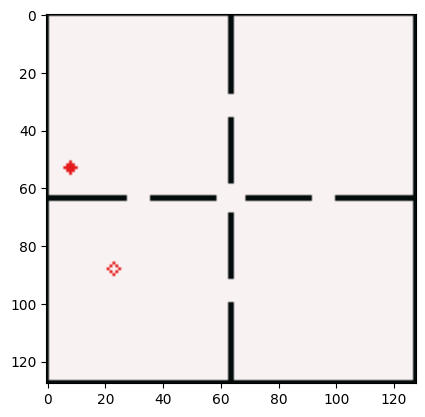

(GlobalBuffer pid=12279) WARNING:absl:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [59]:
env = JaxMANEnv(env_config, 0)
observation_space = env.observation_space
action_space = env.action_space
key = jax.random.PRNGKey(0)
buffer = GlobalBuffer.remote(observation_space, action_space, cfg)
agent, key = create_agent(observation_space,action_space,model_config,key)
agent = restore_agent(agent,True,False,model_config,"../model/navigation_room/continuous_actor_single",)
plt.imshow(env.render())

In [52]:
rollout_fn = _build_rollout_episode(
    env.instance, agent.actor.apply_fn, evaluate=True, model_config=model_config
)
num_data = 0
while num_data < 1000:
    key, subkey = jax.random.split(key)
    carry = rollout_fn(subkey, agent.actor.params, env.instance.obs)
    experience = carry.experience
    buffer.add.remote(experience)
    num_data = ray.get(ray.get(buffer.num_data.remote()))

navigation


In [53]:
original_obs = ray.get(ray.get(buffer.get_batched_data.remote())).observations

In [64]:
base_pos = np.array([0.9,0.45])
original_obs.base_observation[:,5:7]=base_pos
base_mean, base_log_std = agent.actor.apply_fn({"params":agent.actor.params},original_obs)

def compute_actionable_dist(base_mean, base_log_std, mean, log_std):
    def _compute_dist(base_mean, base_log_std, mean, log_std):
        baes_std = jnp.exp(base_log_std)
        std = jnp.exp(log_std)
        kl_dir = (std**2 + (mean-base_mean)**2)/2/baes_std + (baes_std**2 + (mean-base_mean)**2)/2/std - 1
        return kl_dir
    dists = jax.vmap(_compute_dist)(base_mean, base_log_std, mean, log_std)
    return jnp.mean(dists)
dists = np.zeros((20,20))
for i in range(20):
    for j in range(20):
        original_obs.base_observation[:,5:7]=np.array([i/20,j/20])
        # print(np.array([i%20/20,int(i/20)/20]))
        mean, log_std = agent.actor.apply_fn({"params":agent.actor.params},original_obs)
        dist = compute_actionable_dist(base_mean, base_log_std, mean, log_std)
        dists[i,j] = dist

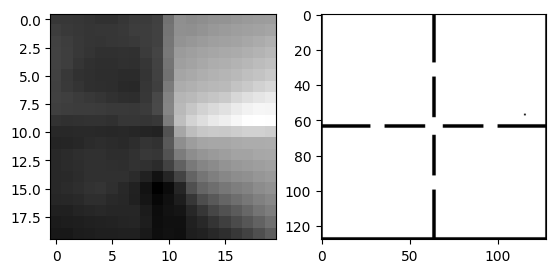

In [65]:
import matplotlib.cm as cm
fig, axes = plt.subplots(1,2)
# dists = np.array(dists).reshape(15,15)
occupancy = np.copy(env.task_info.obs.occupancy)
dists = dists# * (1 - occupancy) + occupancy
axes[0].imshow(dists.T, cmap="binary")
x = int(base_pos[0]*occupancy.shape[0])
y = int(base_pos[1]*occupancy.shape[0])
occupancy[x,y]=1
axes[1].imshow((1-occupancy).T, cmap="gray")